In [50]:
# Load modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import pandas as pd

# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 14
plt.rcParams['font.size'] = font_size

# Add your own import statements if needed

In [94]:
# Load and unpack a compressed npy array
load_data = np.load('data_project2.npz')
data = load_data['arr_0']
print(data.shape)

# Remove data where data[:, -1, 1:5] = 0, i.e.
# where the particles get stuck in (0, 0)
data = data[np.sum(data[:,-1,1:5], axis=1) != 0]
print(data.shape)

# Rng
rng = np.random.default_rng(seed=19)
# rng.shuffle(data)

# Split the data into training and validation sets
t_train = data[:int(data.shape[0]*0.9), :, 0]
x_2_train = data[:int(data.shape[0]*0.9),0,3].reshape(-1,1) @ np.ones((1, 1000))
y_2_train = data[:int(data.shape[0]*0.9),0,4].reshape(-1,1) @ np.ones((1, 1000))

t_val = data[-int(data.shape[0]*0.1)-1:, :, 0]
x_2_val = data[-int(data.shape[0]*0.1)-1:,0,3].reshape(-1,1) @ np.ones((1, 1000))
y_2_val = data[-int(data.shape[0]*0.1)-1:,0,4].reshape(-1,1) @ np.ones((1, 1000))

train_data = np.dstack((t_train, x_2_train, y_2_train))
val_data = np.dstack((t_val, x_2_val, y_2_val))

train_targets = data[:int(data.shape[0]*0.9), :, (1, 2, 3, 4)]
val_targets = data[-int(data.shape[0]*0.1)-1:, :, (1, 2, 3, 4)]

print(train_data.shape)
print(val_data.shape)


(9000, 1000, 9)
(7623, 1000, 9)
(6860, 1000, 3)
(763, 1000, 3)


In [109]:
# Helping functions
def get_data(idx):
    """
    Get one training instance from the data set at the index idx. 
    
    The data is assumed to be in an array `data`.
    
    Args:
        idx (int): An integer specifying which of the training example to fetch
        
    Returns:
        x (array): An array of shape (time_steps, 3) which specifies the input to
                   the neural network. The first column is the time and the second
                   and third columns specify the (x, y) coordinates of the second
                   particle. Note that the first particle is always assumed to be
                   at (1, 0) and the third particle can be inferred from the first
                   and second particle's position.
                   
        y (array): An array of shape (time_steps, 4) which specifies the output that 
                   is expected from the neural network.
                   
                   The first two columns specify the (x, y) coordinates of the first
                   particles and the next two columns give the coordinates of the 
                   second particle for the specified time (length of the columns).
                   The third particles position can be inferred from the first
                   and second particle's position.
    """
    raise NotImplementedError

def get_trajectories(pred):
    """
    Gets the trajectories from a predicted output pred.
    
    Args:
        pred (array): An array of shape (N, 4) where N is the number of time
                      steps. The four columns give the positions of the particles
                      1 and 2 for all the time steps.
    Returns:
        p1, p2, p3 (tuple of arrays): Three arrays of dimensions (N, 2) where N is the number 
                             of time steps and the two columns for each array give 
                             the positions of the three particles (p1, p2, p3)
    """
    x1 = pred[:,:,0];x2 = pred[:,:,2]
    x3 = -x2 - x1
    y1 = pred[:,:,1];y2 = pred[:,:,3]
    y3 = -y1 -y2
    
    p1 = np.dstack((x1, y1))
    p2 = np.dstack((x2, y2))
    p3 = np.dstack((x3, y3))
    return p1, p2, p3 

def plot_trajectories(p1, p2, p3, ax=None, **kwargs):
    """
    Plots trajectories for points p1, p2, p3
    
    Args:
        p1, p2, p3 (array): Three arrays each of shape (n, 2) where n is the number
                            of time steps. Each array is the (x, y) position for the
                            particles
        ax (axis object): Default None, in which case a new axis object is created.
        kwargs (dict): Optional keyword arguments for plotting
        
    Returns:
        ax: Axes object
    """
    raise NotImplementedError


In [96]:

def norm_data(X):
    X_avg = X.mean()
    X_std = X.std()
    X_new = (X - X_avg)/X_std
    return X_new, X_avg, X_std

def unnormdata(X,old_avg,old_std):
    X_new = X * old_std[0] + old_avg[0]
    return X_new

def save_model(model, model_name):
    model_name = 'non_tuned_model'
    model.save(f'PATH/{model_name}.keras')    

def plot_history(history,model_name, save_training_curves = False):
    plt.figure(figsize=(8,6))
    for key in history.history.keys():
        plt.plot(history.history[key],label=key)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    if save_training_curves:
        plt.savefig(f'Training curve {model_name}.pdf')
        

In [97]:
pre_trained_model = keras.models.load_model('Breen_NN_project2.keras')
#pre_trained_model.summary()
pre_trained_model.trainable = False

batch_size = 5000

train_dataset = tf.data.Dataset.from_tensor_slices((train_data.reshape(-1,3), train_targets.reshape(-1,4))).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data.reshape(-1,3), val_targets.reshape(-1,4))).batch(batch_size)

pre_trained_model.summary(show_trainable=True)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ dense_78 (Dense)            │ (None, 128)           │        512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_79 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_80 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_81 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_82 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_83 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_84 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_85 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_86 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_87 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_88 (Dense)            │ (None, 4)             │        516 │   N   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 149,636 (1.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 149,636 (1.14 MB)

In [98]:
model_5_Dense = keras.models.Sequential([   
    keras.layers.Dense(64, activation='relu', input_shape=(3,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4)
])

model_CNN = keras.models.Sequential([
    keras.layers.Conv1D(filters = 128, kernel_size = 3, activation='relu',input_shape=(3,1)),
    keras.layers.Flatten(),
    keras.layers.Dense(4)
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [99]:
def training_models(model,epochs, train_data, val_data, loss_function=keras.losses.MeanAbsoluteError(), metric='mean_absolute_error', learning_rate=0.001, patience=15):

    ''' Function to train a model and return the history, model and time taken to train'''


    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,mode='min',restore_best_weights = True)

    model.compile(loss=loss_function,
                optimizer=tf.optimizers.Adam(learning_rate,0.5,0.5),
                metrics=[metric])

    start = time.time()
    history = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[early_stopping])
    end = time.time()
    t = end-start
    print(f'Time to run: {t:.1f}s')

    return history,model,t

In [131]:
# Trandferred model

#name_of_last_layer = 'dense_87'

#print(pre_trained_model.get_layer(name_of_last_layer).output)
#x = pre_trained_model.get_layer(name_of_last_layer).output
#x = keras.layers.Dense(units=64, activation='relu')(x)
#x = keras.layers.Dense(units=64, activation='relu')(x)

#x = keras.layers.Dense(4,activation='relu')(x)

# Creating new combined model. Note that this is NOT a Sequential() model.
#model = keras.models.Model(inputs=pre_trained_model.input, outputs=x)

#print(model.summary(show_trainable=True))

In [100]:
epochs = 100
history, model, t = training_models(model_5_Dense, epochs, train_dataset, val_dataset)

#history_cnn, model_CNN, t_cnn =  training_models(model_CNN, epochs, train_dataset, val_dataset)


#history, model, t = training_models(pre_trained_model, 100, 'mean_squared_error', 'mean_squared_error', 0.001, 10, train_dataset, val_dataset)

Epoch 1/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.2658 - mean_absolute_error: 0.2658 - val_loss: 0.1716 - val_mean_absolute_error: 0.1716
Epoch 2/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1702 - mean_absolute_error: 0.1702 - val_loss: 0.1374 - val_mean_absolute_error: 0.1374
Epoch 3/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1486 - mean_absolute_error: 0.1486 - val_loss: 0.1262 - val_mean_absolute_error: 0.1262
Epoch 4/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1350 - mean_absolute_error: 0.1350 - val_loss: 0.1258 - val_mean_absolute_error: 0.1258
Epoch 5/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1282 - mean_absolute_error: 0.1282 - val_loss: 0.1260 - val_mean_absolute_error: 0.1260
Epoch 6/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1233 - mean_absolute_error: 0.1233 - val_loss: 0.1124 - val_mean_absolute_error: 0.1124
Epoch 7/100
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1176 - mea

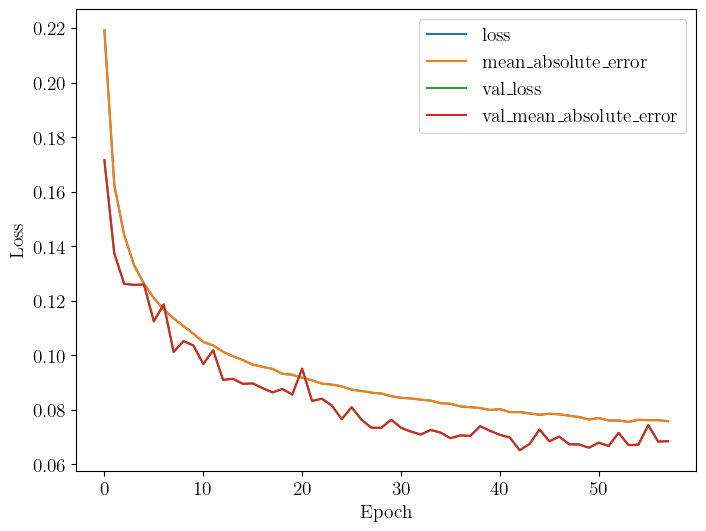

In [107]:
# Plot the training curves
plot_history(history, 'model_5_Dense', save_training_curves = False)

In [102]:

trad = np.zeros((val_targets.shape[0],val_targets.shape[1],4))
for time_step in range(val_targets.shape[1]):
    if time_step == 0:
        trad[:,time_step,:] = val_targets[:,time_step,:]
    else:
        trad[:,time_step,:] = model_5_Dense.predict(val_data[:,time_step,:],verbose=0) 

print(trad.shape)

(763, 1000, 4)


(763, 1000, 2)


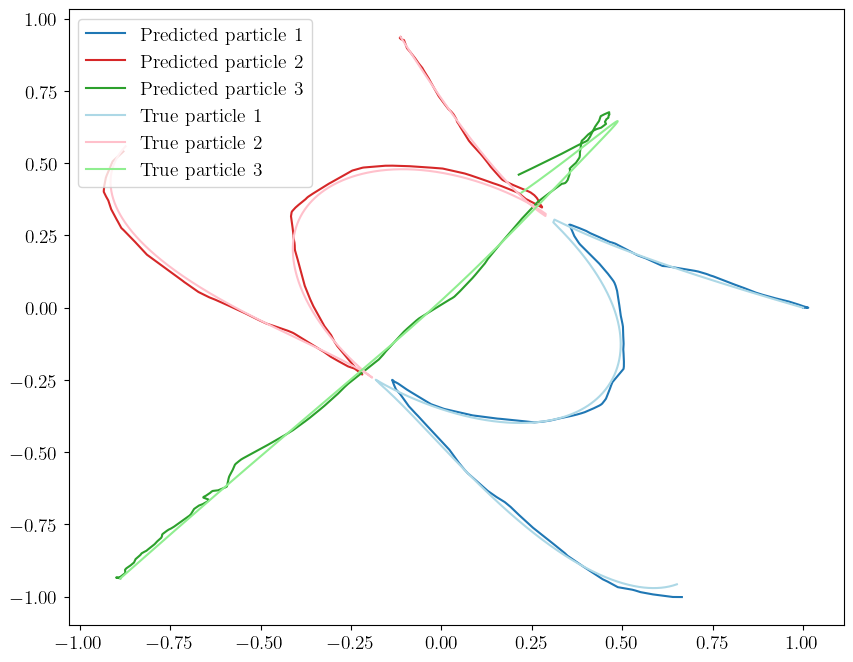

In [149]:

print(p1.shape)

nrand = rng.integers(0, val_targets.shape[0])

plt.figure(figsize=(10,8))

p1, p2, p3 = get_trajectories(trad)
plt.plot(p1[nrand,:,0],p1[nrand,:,1],label='Predicted particle 1', color = 'tab:blue')
plt.plot(p2[nrand,:,0],p2[nrand,:,1],label='Predicted particle 2',color='tab:red')
plt.plot(p3[nrand,:,0],p3[nrand,:,1],label='Predicted particle 3',color = 'tab:green')

p1, p2, p3 = get_trajectories(val_targets)
plt.plot(p1[nrand,:,0],p1[nrand,:,1],label='True particle 1',color = 'lightblue')
plt.plot(p2[nrand,:,0],p2[nrand,:,1],label='True particle 2',color = 'pink')
plt.plot(p3[nrand,:,0],p3[nrand,:,1],label='True particle 3',color = 'lightgreen')

plt.legend()


Text(0, 0.5, '$y$')

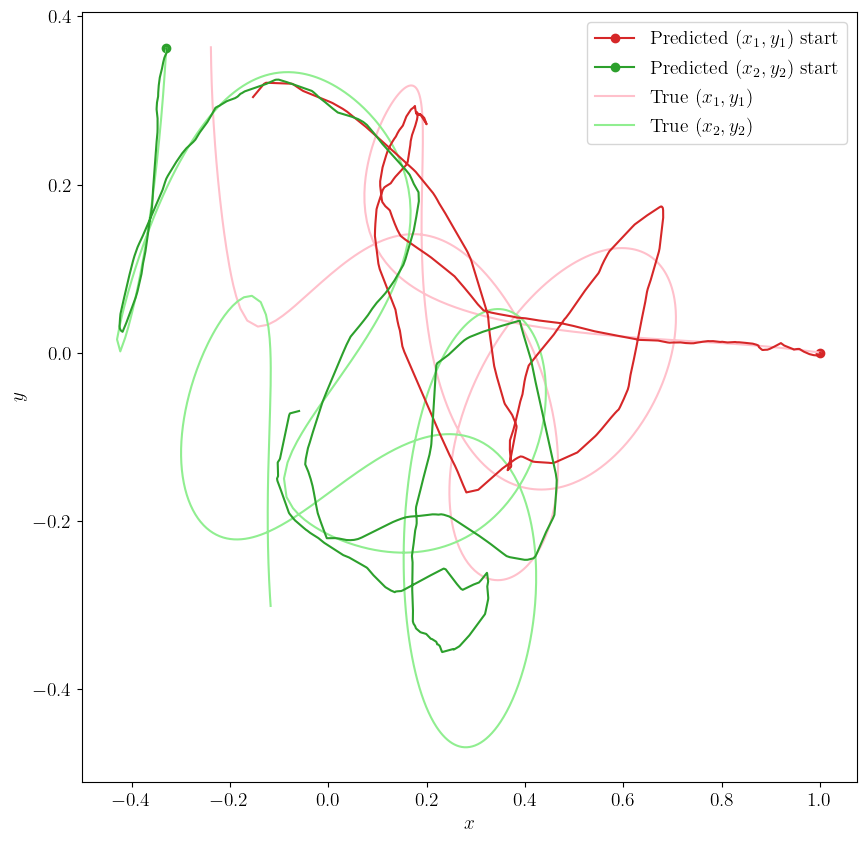

In [106]:
rand_n = rng.integers(0,val_data.shape[0])

plt.figure(figsize=(10,10))

plt.plot(trad[rand_n,0,0],trad[rand_n,0,1], color='tab:red',marker='o',label='Predicted $(x_1,y_1)$ start')
plt.plot(trad[rand_n,0,2],trad[rand_n,0,3], color='tab:green',marker='o',label='Predicted $(x_2,y_2)$ start')
plt.plot(val_targets[rand_n,:,0],val_targets[rand_n,:,1],label='True $(x_1,y_1)$',color = 'pink')
plt.plot(val_targets[rand_n,:,2],val_targets[rand_n,:,3],label='True $(x_2,y_2)$',color = 'lightgreen')
plt.legend()
plt.plot(trad[rand_n,:,0],trad[rand_n,:,1],label='Predicted $(x_1,y_1)$', color='tab:red')
plt.plot(trad[rand_n,:,2],trad[rand_n,:,3],label='Predicted $(x_2,y_2)$',color = 'tab:green')


plt.xlabel('$x$')
plt.ylabel('$y$')
